In [59]:
import multiprocessing
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchio as tio

from scripts.utils.memory import get_total_memory
from scripts.utils.visualization import *
from scripts.load_data import *
from scripts.train import *
from scripts.extract_ROI import extract_ROI 
from scripts.analysis import *
from scripts.preprocessing import split_training_data




seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(True, warn_only=True)

num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)
print('Device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last run on Tue Jul 18 12:07:08 2023
TorchIO version: 0.18.92
Device: cuda


# Data Loading and Visualization

In [35]:
metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")

In [8]:
padding_size = 10
crop_size = 128

In [9]:
# data_dir = "Data_original/OpenDataset/Training/Labeled/"
# destination_dir = "Data/M&Ms/OpenDataset/Labeled/"
# extract_ROI(data_dir, destination_dir, metadata_path, crop_size=crop_size ,padding_size=padding_size)

In [10]:
# data_dir = "Data_original/OpenDataset/Testing/"
# destination_dir = "Data/M&Ms/OpenDataset/Testing/"
# extract_ROI(data_dir, destination_dir, metadata_path, crop_size=crop_size ,padding_size=padding_size)

In [11]:
""" data_dir = "Data_original/OpenDataset/Validation/"
destination_dir = "Data/M&Ms/OpenDataset/Validation/"
extract_ROI(data_dir, destination_dir, metadata_path, crop_size=crop_size,padding_size=padding_size) """

' data_dir = "Data_original/OpenDataset/Validation/"\ndestination_dir = "Data/M&Ms/OpenDataset/Validation/"\nextract_ROI(data_dir, destination_dir, metadata_path, crop_size=crop_size,padding_size=padding_size) '

In [12]:
metadata = split_training_data(metadata, train_ratio=0.8)

vendors = list(metadata.Vendor.unique())

transform = tio.RescaleIntensity((0, 1))
vendor_datasets_3D = []
for vendor in vendors:
    vendor_datasets_3D.append(load_vendor_3D(vendor, metadata, transform))


""" for i in range(4):
    visualize_subject(vendor_datasets_3D[i][0]) """

317it [00:15, 21.13it/s]


Data/M&Ms/OpenDataset/ Dataset size: 76 subjects


317it [00:21, 14.57it/s]


Data/M&Ms/OpenDataset/ Dataset size: 125 subjects


317it [00:03, 88.41it/s] 


Data/M&Ms/OpenDataset/ Dataset size: 19 subjects


317it [00:08, 35.26it/s] 


Data/M&Ms/OpenDataset/ Dataset size: 50 subjects


317it [00:08, 37.88it/s] 

Data/M&Ms/OpenDataset/ Dataset size: 47 subjects


# Train on only one Vendor 

In [52]:
train_dataset = load_vendor_2D("F", metadata, transform)
valid_dataset = load_vendor_2D("A", metadata, transform)

print("Train dataset length:", len(train_dataset))
print("Validation dataset length:", len(valid_dataset))

total number of samples: 95, train samples: 76, Validation: 19


317it [00:11, 28.32it/s]


Data/M&Ms/OpenDataset/ Dataset size: 1770 subjects


317it [00:02, 107.94it/s]


Data/M&Ms/OpenDataset/ Dataset size: 442 subjects
Train dataset length: 1770
Validation dataset length: 442


In [64]:
num_epochs = (30)
batch_size = 32
num_classes = 4
num_workers = 10
save = True
model_name = "baseline"
save_best=False

model, optimizer, criterion = initialize_model()

model = train_model(model, 
                    optimizer, 
                    criterion,
                    device,  
                    train_dataset, 
                    valid_dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    num_epochs=num_epochs,
                    verbose=3,
                    save=save,
                    model_name= model_name,
                    save_best=save_best
                    )

  3%|▎         | 1/30 [00:03<01:30,  3.13s/it]

Epoch [1/30]], Loss: 0.8955, Validation Loss: 1.5130


 37%|███▋      | 11/30 [00:34<00:59,  3.11s/it]

Epoch [11/30]], Loss: 0.0847, Validation Loss: 0.1704


 70%|███████   | 21/30 [01:05<00:28,  3.18s/it]

Epoch [21/30]], Loss: 0.0467, Validation Loss: 0.1677


100%|██████████| 30/30 [01:34<00:00,  3.15s/it]


In [68]:
model, optimizer, criterion = initialize_model()

In [71]:
model.

<bound method Module.parameters of UNet(
  (encoder): Encoder(
    (encoding_blocks): ModuleList(
      (0): EncodingBlock(
        (conv1): ConvolutionalBlock(
          (conv_layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation_layer): PReLU(num_parameters=1)
          (block): Sequential(
            (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): PReLU(num_parameters=1)
          )
        )
        (conv2): ConvolutionalBlock(
          (conv_layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (norm_layer): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation_layer): PReLU(num_parameters=1)
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Stopping Epoch is: 30


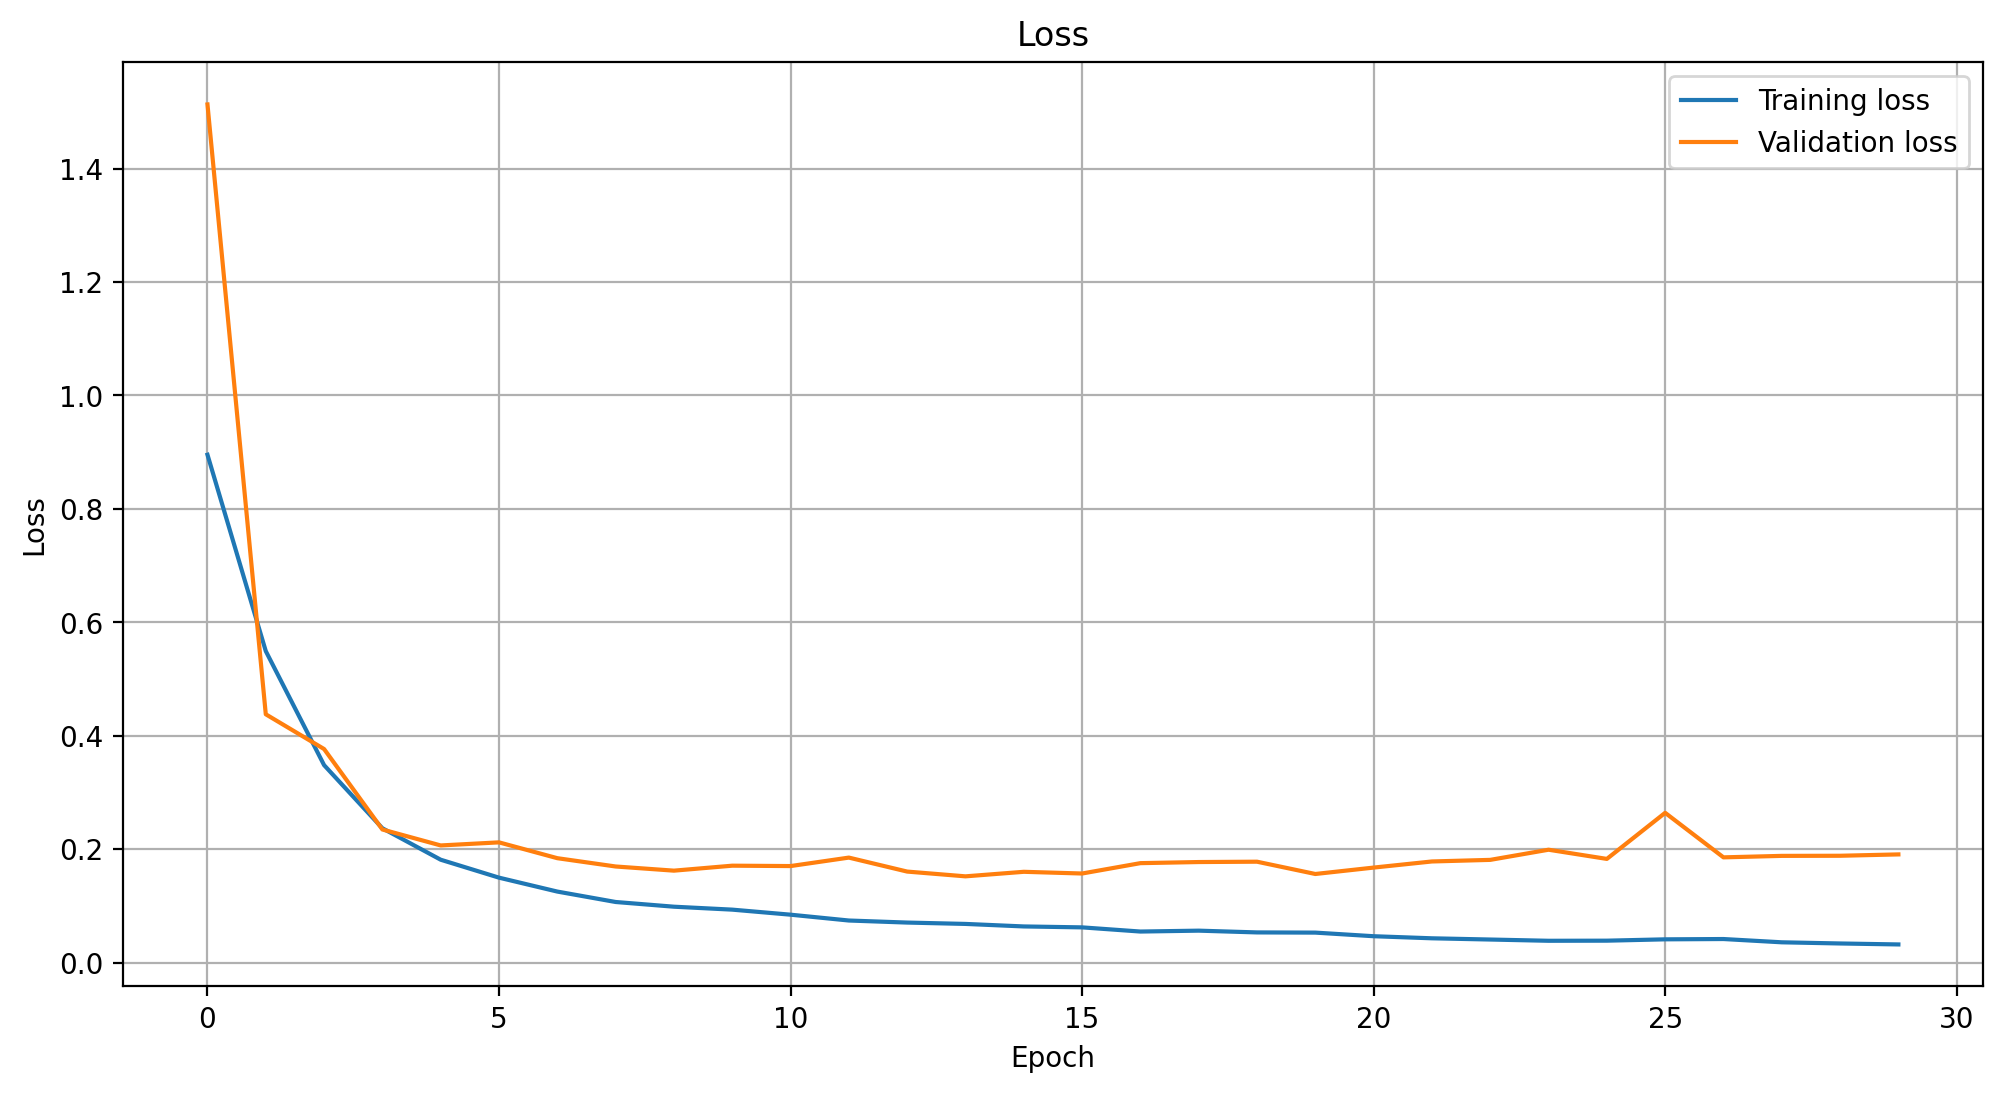

In [65]:
model, optimizer = load_model(model_name, show_performance=True)

In [55]:
""" for i in range(len(vendors)):
    # Get data for one subject
    one_subject = vendor_datasets_3D[i][0]
    visualize_predictions_3D(model, one_subject, device) """

' for i in range(len(vendors)):\n    # Get data for one subject\n    one_subject = vendor_datasets_3D[i][0]\n    visualize_predictions_3D(model, one_subject, device) '

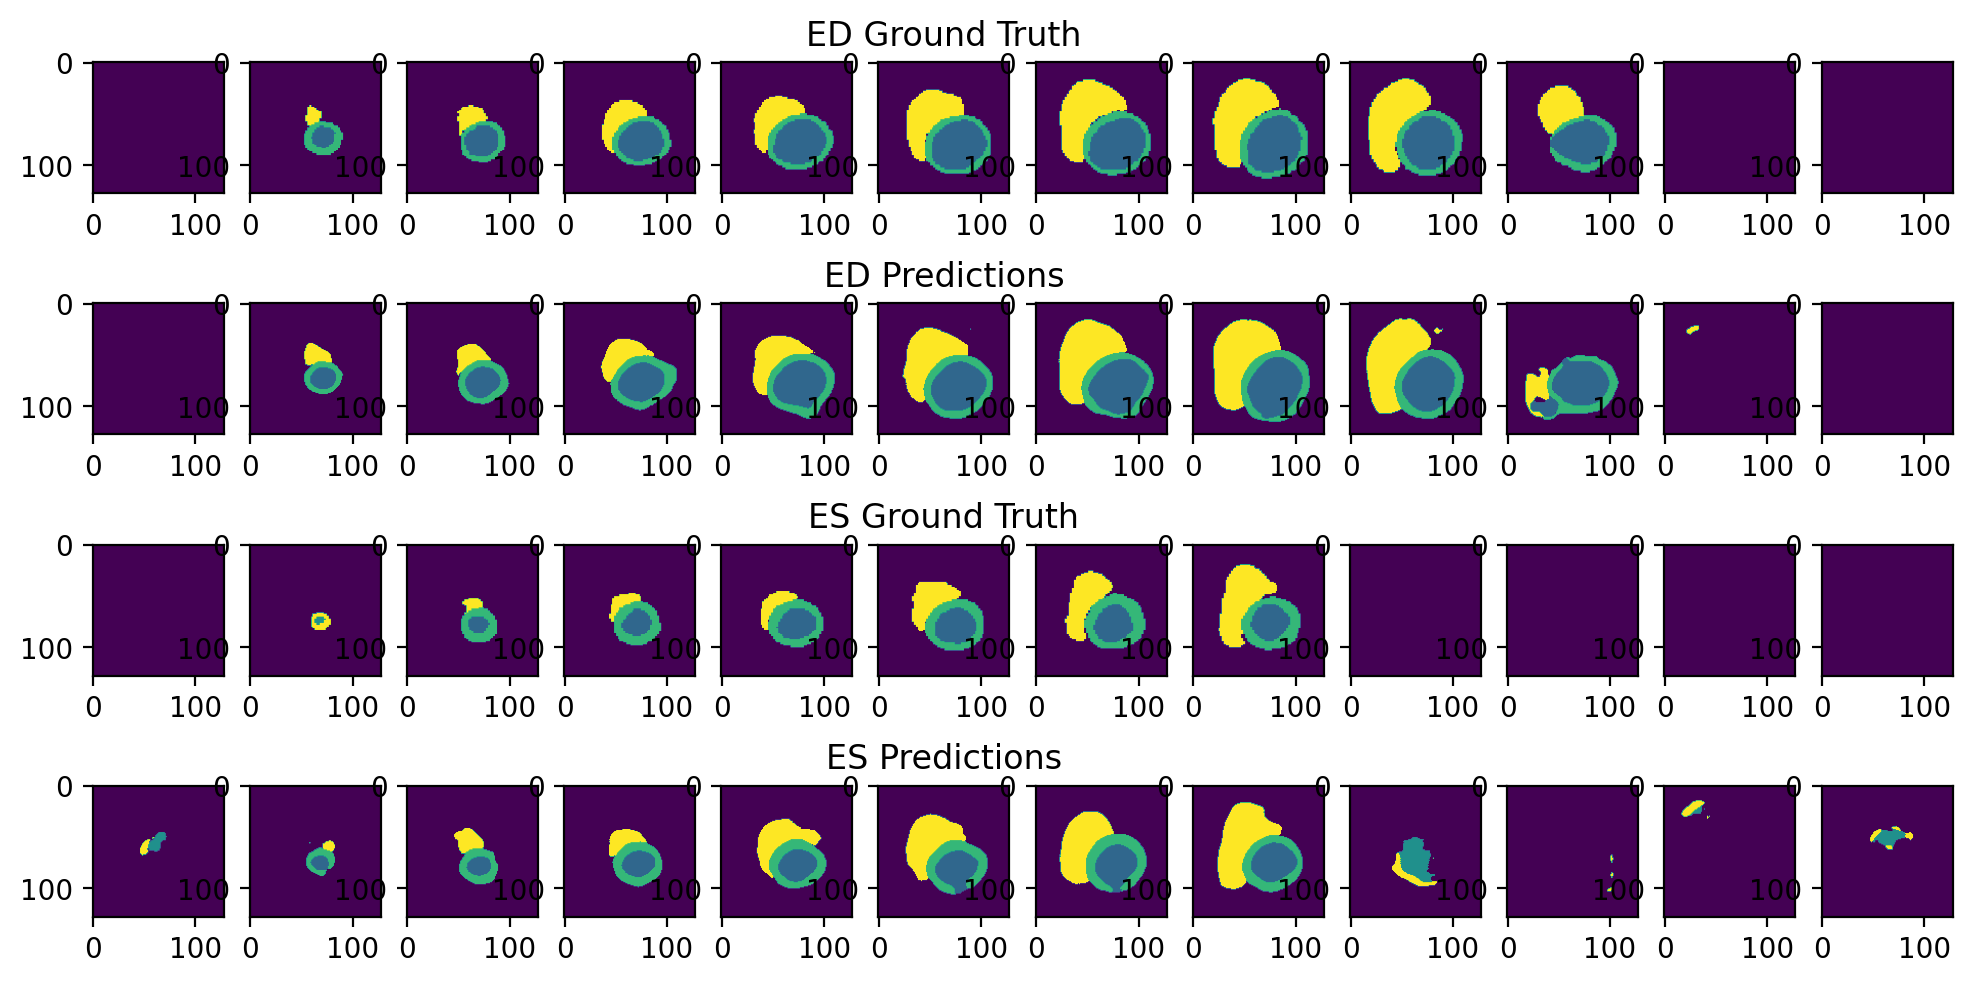

In [62]:
save_results(model_name, device, metadata, vendor_datasets_3D, show_example=True)

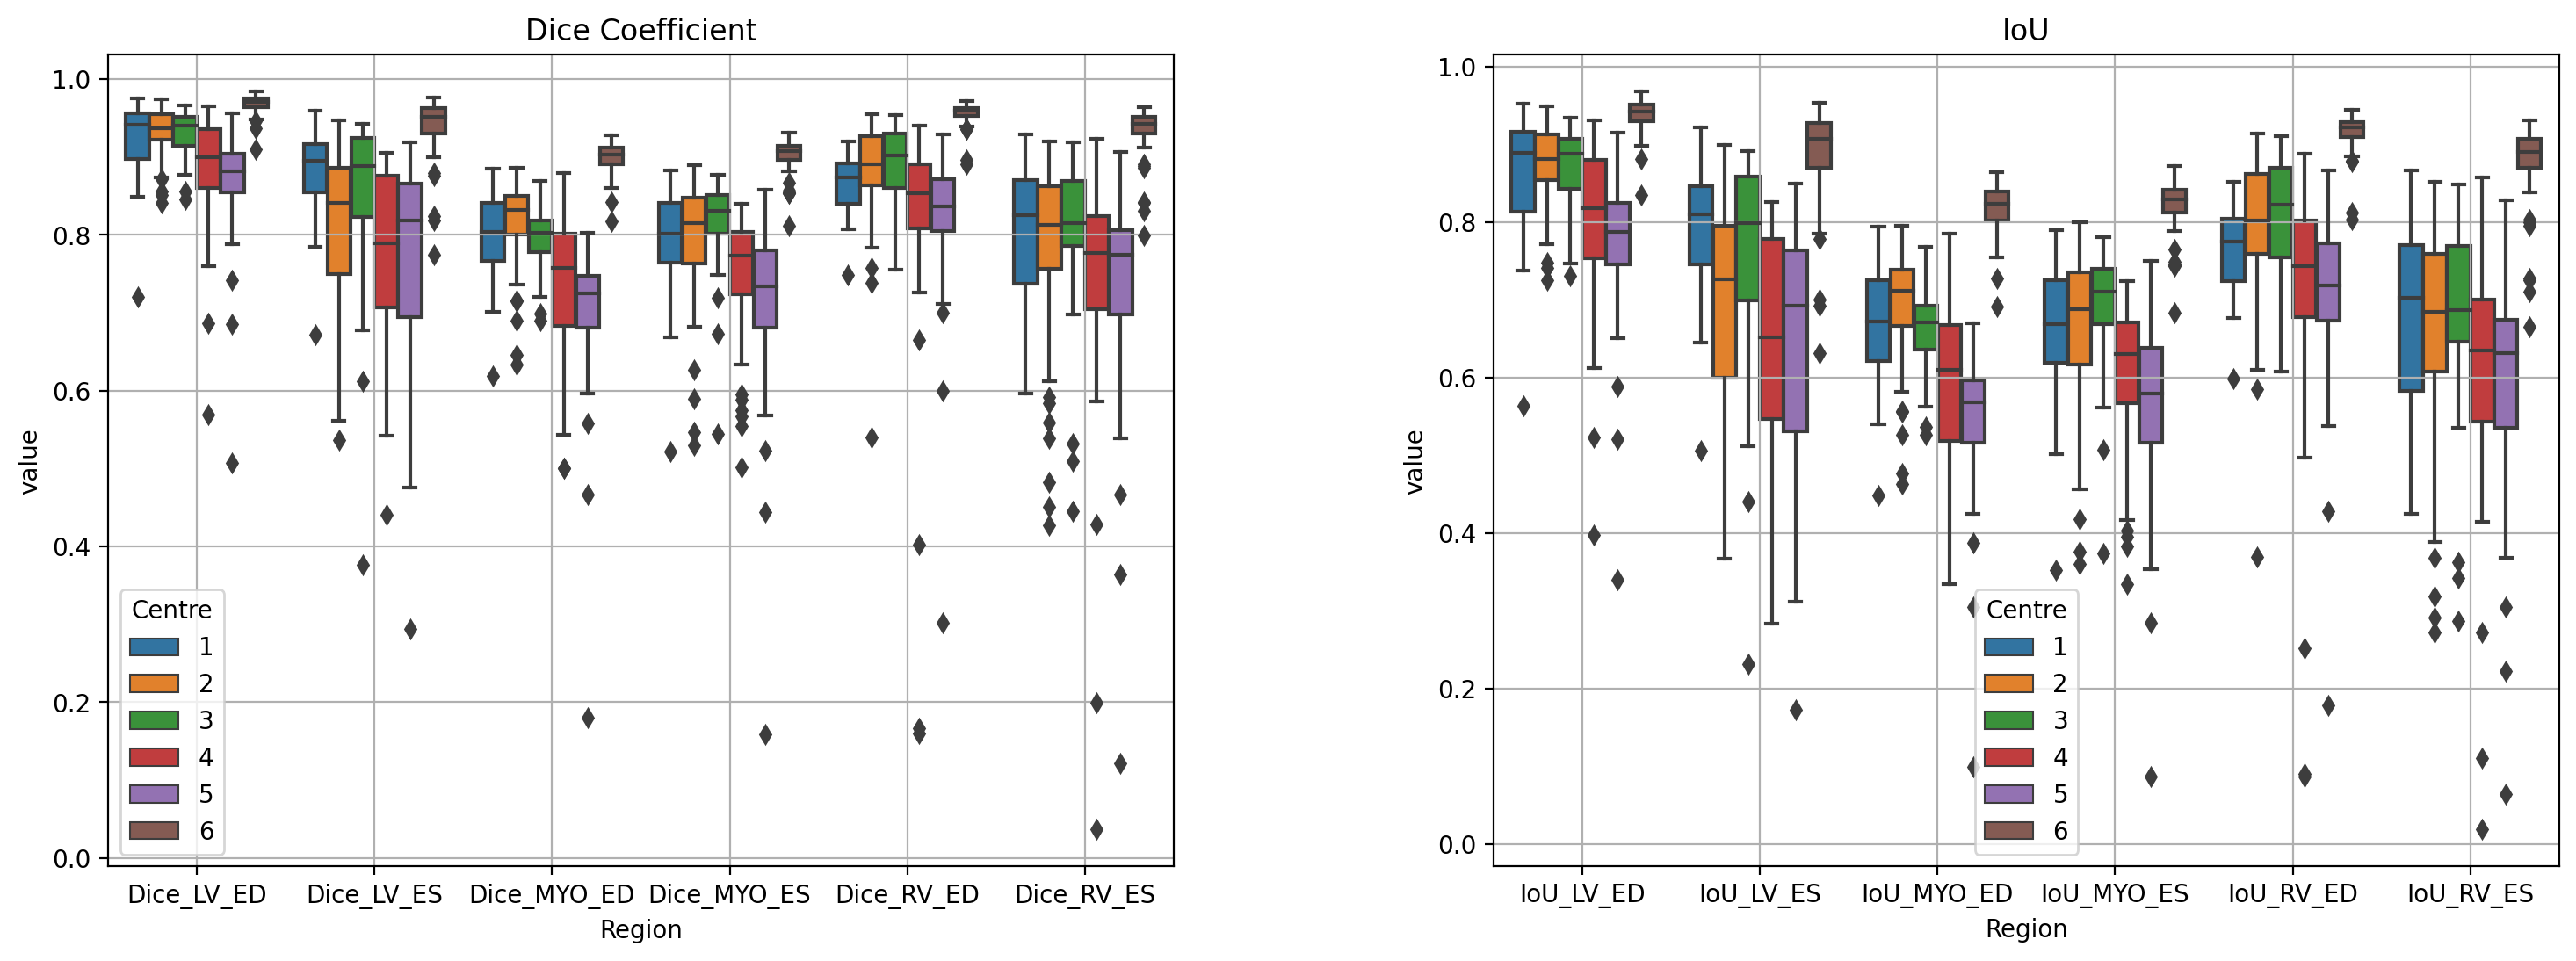

Dice_BG_ED  Dice_LV_ED  Dice_MYO_ED  Dice_RV_ED  Dice_BG_ES  \
Vendor Centre                                                                
A      1         0.974612    0.916953     0.796764    0.864529    0.981362   
B      2         0.977811    0.932093     0.817059    0.883575    0.981426   
       3         0.980145    0.932203     0.797035    0.889269    0.984163   
C      4         0.975660    0.883975     0.734929    0.812839    0.980161   
D      5         0.968655    0.868668     0.701494    0.819801    0.975031   
F      6         0.992804    0.967702     0.898926    0.955880    0.994746   

               Dice_LV_ES  Dice_MYO_ES  Dice_RV_ES  IoU_BG_ED  IoU_LV_ED  \
Vendor Centre                                                              
A      1         0.876765     0.789465    0.802403   0.950661   0.851739   
B      2         0.806296     0.793502    0.787022   0.956709   0.874261   
       3         0.851638     0.817040    0.803663   0.961167   0.874255   
C      4         0.775023     0.747048    0.740866   0.952628   0.799523   
D      5         0.770956     0.710239    0.735707   0.939594   0.773820   
F      6         0.940005     0.902605    0.934609   0.985719   0.937655   

               IoU_MYO_ED  IoU_RV_ED  IoU_BG_ES  IoU_LV_ES  IoU_MYO_ES  \
Vendor Centre                                                            
A      1         0.667361   0.763836   0.963547   0.787033    0.658922   
B      2         0.693633   0.796241   0.963687   0.686530    0.663243   
       3         0.664502   0.804156   0.968939   0.753611    0.693991   
C      4         0.589067   0.707543   0.961199   0.646203    0.602782   
D      5         0.547462   0.703991   0.951545   0.644078    0.560774   
F      6         0.816959   0.915783   0.989553   0.888773    0.823064   

               IoU_RV_ES  
Vendor Centre             
A      1        0.678199  
B      2        0.660678  
       3        0.681301  
C      4        0.609116  
D      5        0.596987  
F      6        0.878637

In [63]:
grouped_by_vendor = show_results(model_name)
grouped_by_vendor